In this section we will provide the results from four modeling approaches.  Three of these 
modeling approaches are defined for you, and you get to choose the fourth approach from the 
list of choices.   
    - For each model provide any relevant or useful model output and a table of the model
    performance in-sample (i.e. on the training data set) and out-of-sample (i.e. on the test data set).   
    - The metrics to be measured are:   
        (1) true positive rate or sensitivity  
        (2) false positive rate  
        (3) the accuracy.  
 
5.a Random Forest  
    - Include the variable importance plot.  
 
5.b Gradient Boosting  
    - Use GBM or XGBoost packages.  Include the variable importance plot.  

5.c Logistic Regression with Variable Selection   
    - Random Forest and Gradient Boosting will identify a pool of interesting predictor 
    variables.  Use that information to help you choose an initial pool of predictor variables.   
    List your initial pool of predictor variables in a table.   
    - Choose a variable selection algorithm.  Use that variable selection algorithm to arrive at 
    an ‘optimal’ logistic regression model.  
    - Since this is a linear model, you should provide a table of the model coefficients and 
    their p-values.  
 
5.d Your Choice – CHAID, Neural Network, SVM, or some other method appropriate for 
binary classification.   
    - Provide the relevant output for the model of choice.  For example SVM has margin 
    plots that are useful, and a neural network allows you to plot out the network topology.  If 
    your chosen method has a ‘standard’ plot that is typically shown with it, then we all 
    expect to see that plot, and you should be providing that plot with the model.

In [20]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [21]:
credit_card_default_raw = pd.read_csv('./Data/credit_card_default.csv')
# credit_card_default_eng = pd.read_csv('./Data/credit_card_default_eng.csv')
result = pyreadr.read_r('./Data/credit_card_default_eng_features.RData') 
credit_card_default_eng = result[None]

credit_card_default = credit_card_default_eng.copy()
df_flags = credit_card_default_raw[['data.group', 'DEFAULT']]
df_other_features = credit_card_default_raw[['SEX','EDUCATION','MARRIAGE','AGE']]
credit_card_default = credit_card_default.join(df_flags)
credit_card_default = credit_card_default.join(df_other_features)


In [22]:
credit_card_default = credit_card_default[['pay_max', 'ratio_avg','balance_growth_6mo','payment_avg','data.group','DEFAULT']]

In [23]:

display(credit_card_default.describe())
display(credit_card_default.head())

,pay_max,ratio_avg,balance_growth_6mo,payment_avg,data.group,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.682200,0.576423,-0.090664,5275.232094,1.743900,0.221200
std,1.073518,16.499616,0.279674,10137.946323,0.830864,0.415062
min,0.000000,0.000000,-4.700400,0.000000,1.000000,0.000000
25%,0.000000,0.047855,-0.146863,1113.291667,1.000000,0.000000
50%,0.000000,0.197668,-0.004382,2397.166667,1.000000,0.000000
75%,2.000000,0.903817,0.028105,5583.916667,2.000000,0.000000
max,8.000000,2667.199955,1.791100,627344.333333,3.000000,1.000000


,pay_max,ratio_avg,balance_growth_6mo,payment_avg,data.group,DEFAULT
0,2.0,0.800000,-0.195650,114.833333,1,1
1,2.0,0.193583,0.006442,833.333333,3,1
2,0.0,0.083968,-0.158789,1836.333333,1,0
3,0.0,0.039794,-0.360620,1398.000000,3,0
4,0.0,0.471997,0.210580,9841.500000,3,0


In [24]:
credit_card_default.dtypes

pay_max               float64
ratio_avg             float64
balance_growth_6mo    float64
payment_avg           float64
data.group              int64
DEFAULT                 int64
dtype: object

In [25]:
ccd_train = credit_card_default[credit_card_default['data.group']==1].drop(columns='data.group')
ccd_test = credit_card_default[credit_card_default['data.group']==2].drop(columns='data.group')
ccd_validate = credit_card_default[credit_card_default['data.group']==3].drop(columns='data.group')

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (15180, 5)
test data size: (7323, 5)
validate data size: (7497, 5)


In [26]:
X = credit_card_default.drop(columns='data.group')
X_train = ccd_train.drop(columns='DEFAULT')
X_train_official = ccd_train.drop(columns='DEFAULT') # _official is for k_fold or other resplitting methods that would change defn
X_test = ccd_test.drop(columns='DEFAULT')
X_test_official = ccd_test.drop(columns='DEFAULT')

y = credit_card_default['DEFAULT']
y_train = ccd_train['DEFAULT']
y_train_official = ccd_train['DEFAULT']
y_test = ccd_test['DEFAULT']
y_test_official = ccd_test['DEFAULT']

Prep for modeling

In [27]:
all_features = credit_card_default_eng.columns
all_features = all_features.tolist()

In [28]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['pay_max', 'ratio_avg', 'balance_growth_6mo', 'payment_avg']

[]

In [29]:
### we've done our own splitting

# #import train_test_split library
# from sklearn.model_selection import train_test_split

# # create train test split
# y_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [30]:
preprocessor = make_column_transformer( 
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [31]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )

5.a Model
source: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

In [32]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()


In [33]:
logisticRegr.fit(X_train, y_train)


LogisticRegression()

In [34]:
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test_official, y_test_official)
score

0.7954390277208794

,precision,recall,f1-score,support
0,0.80,0.98,0.88,5766.0
1,0.60,0.11,0.19,1557.0
accuracy,0.80,0.80,0.80,0.8
macro avg,0.70,0.55,0.54,7323.0
weighted avg,0.76,0.80,0.74,7323.0


[[5646  120]
 [1378  179]]


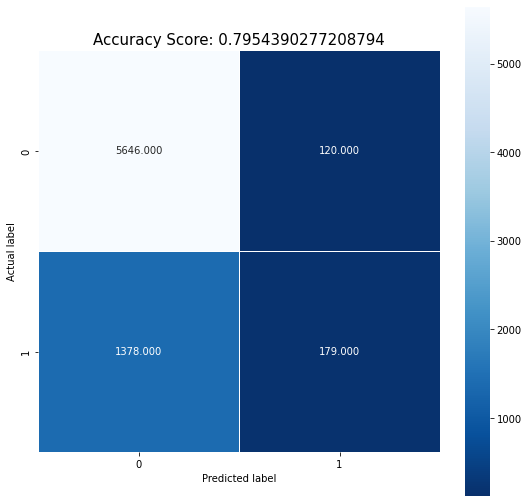

In [35]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


[[5646  120]
 [1378  179]]


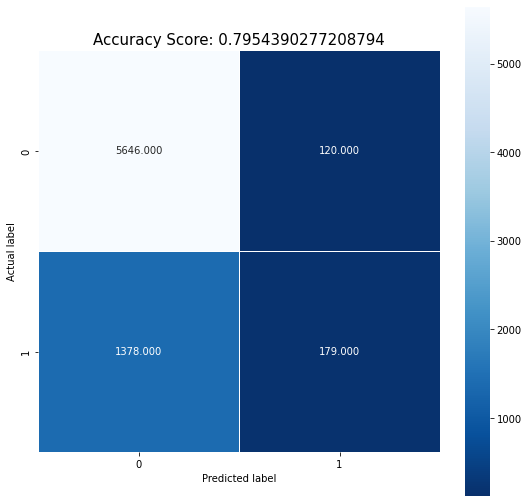

In [36]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


review imbalance  
source: https://machinelearningmastery.com/cost-sensitive-logistic-regression/

In [37]:
from collections import Counter
from sklearn.datasets import make_classification
from numpy import where

# summarize class distribution
counter = Counter(y)
print(counter)

Counter({0: 23364, 1: 6636})


In [38]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

InvalidIndexError: (array([    0,     1,    13, ..., 29997, 29998, 29999], dtype=int64), 0)

In [39]:
# fit a logistic regression model on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# generate dataset
X_train, y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=2)
# define model
logReg3 = LogisticRegression(solver='lbfgs')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(logReg3, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.985


In [41]:
logReg3.fit(X_train, y_train)
predictions = logReg3.predict(X_test)
score = logReg3.score(X_test, y_test)
score

c:\Users\steve\miniconda3\envs\sklearn\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: X has 4 features, but LogisticRegression is expecting 2 features as input.

previous kfold overfit quickly  
try weighting

In [42]:
# define model
weights = {0:1.0, 1:4.0}
model = LogisticRegression(solver='lbfgs', class_weight=weights)

In [43]:
# weighted logistic regression model on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=2)
# define model
weights = {0:0.01, 1:1.0}
model = LogisticRegression(solver='lbfgs', class_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.989


In [45]:
predictions = cv.predict(X_test)
score = model.score(X_test, y_test)
score

AttributeError: 'RepeatedStratifiedKFold' object has no attribute 'predict'

determine correct weighting  
source: https://machinelearningmastery.com/cost-sensitive-logistic-regression/#:~:text=for%20each%20class.-,Weighted%20Logistic%20Regression%20with%20Scikit%2DLearn,-The%20scikit%2Dlearn

In [46]:
# calculate heuristic class weighting
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
# generate 2 class dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=2)
# calculate class weighting
weighting = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = y)
print(weighting)

[ 0.50505051 50.        ]


In [47]:
logReg4 = LogisticRegression(solver='lbfgs', class_weight=weighting)
logReg4.fit(X_train_official,y_train_official)

c:\Users\steve\miniconda3\envs\sklearn\lib\site-packages\sklearn\linear_model\_logistic.py:329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


LogisticRegression(class_weight=array([ 0.50505051, 50.        ]))

In [48]:
predictions = logReg4.predict(X_test)
score = logReg4.score(X_test, y_test)
score

0.7954390277208794

[[5646  120]
 [1378  179]]


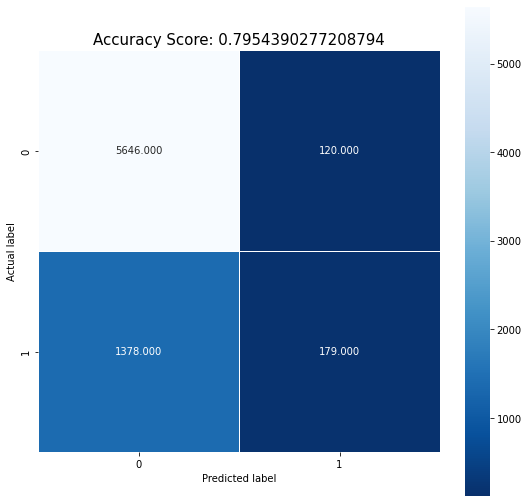

In [49]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


coeffs/p-values

In [52]:
logReg4.coef_

array([[ 7.45264074e-01, -1.69612866e-03,  1.58184689e-01,
        -3.40409236e-05]])

In [54]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.054742
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Aug 2022   Pseudo R-squ.:                 0.02248
Time:                        18:50:40   Log-Likelihood:                -547.42
converged:                       True   LL-Null:                       -560.02
Covariance Type:            nonrobust   LLR p-value:                 5.218e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.5037      0.245     26.572      0.000       6.024       6.983
x2            -2.0074      0